<a href="https://colab.research.google.com/github/lucastanger/rock_paper_scissors/blob/main/rock_paper_scissors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rock Paper Scissors Classification with CNN (Convolutional Neural Network)



*   See [GitHub](https://github.com/lucastanger/rock_paper_scissors) Repository for further information 



In [ ]:
# Select Tensorflow version v2
%tensorflow_version 2.x

In [ ]:
# Import required libs
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import random

# Print information
print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

In [ ]:
# Check if GPU is available
print(f'Available GPUs: {len(tf.config.list_physical_devices("GPU"))}')
print(f'Available TPUs: {len(tf.config.list_physical_devices("TPU"))}')

## Loading the dataset

In [ ]:
# See available datasets
# tfds.list_builders()

In [ ]:
# Select dataset by name
D_NAME = 'rock_paper_scissors'

# Load dataset
(data_train, data_test), ds_info = tfds.load(
        name=D_NAME, 
        split=['train', 'test'],
        with_info=True,
        as_supervised=True
        )

In [ ]:
print(f'Size of TRAIN data: {len(list(data_train))}')
print(f'Size of TEST data: {len(list(data_test))}')

## Dataset exploration

In [ ]:
ds_info

In [ ]:
# Function to resolve number -> label
get_label_name = ds_info.features['label'].int2str

In [ ]:
# Resolve some labels
labels = [get_label_name(0),get_label_name(1),get_label_name(2)]

print(labels)

In [ ]:
def reshape_c(image, label):
    # Cast values to tf.float32
    image = tf.cast(image, tf.float32)
    # Divide all values by 255
    image = image / 255.
    # Resize imagesize
    image = tf.image.resize(image, [150,150])
    # Return the reshaped image
    return image, label

In [ ]:
data_train = data_train.map(reshape_c)
data_test = data_test.map(reshape_c)

In [ ]:
ds_info.features['label'].num_classes

In [ ]:
# Own function, just like tfds.show_examples - but without downloading the dataset
def examples(ds):
  # Create a 3x3 plot for the examples
  fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,20))
  # Flatten axes for iteration
  ax = ax.flatten()

  fig.suptitle(f'{ds_info.description}')

  for i, feats in enumerate(ds.take(9)):
    # Safe Feature into Tensor-like shape (image,label)
    (image,label) = feats
    # Plot example image
    lbl = get_label_name(label.numpy())
    # Add title to subplot
    ax[i].set_title(f'{lbl}')
    # Add image to subplot
    ax[i].imshow(image.numpy())

  

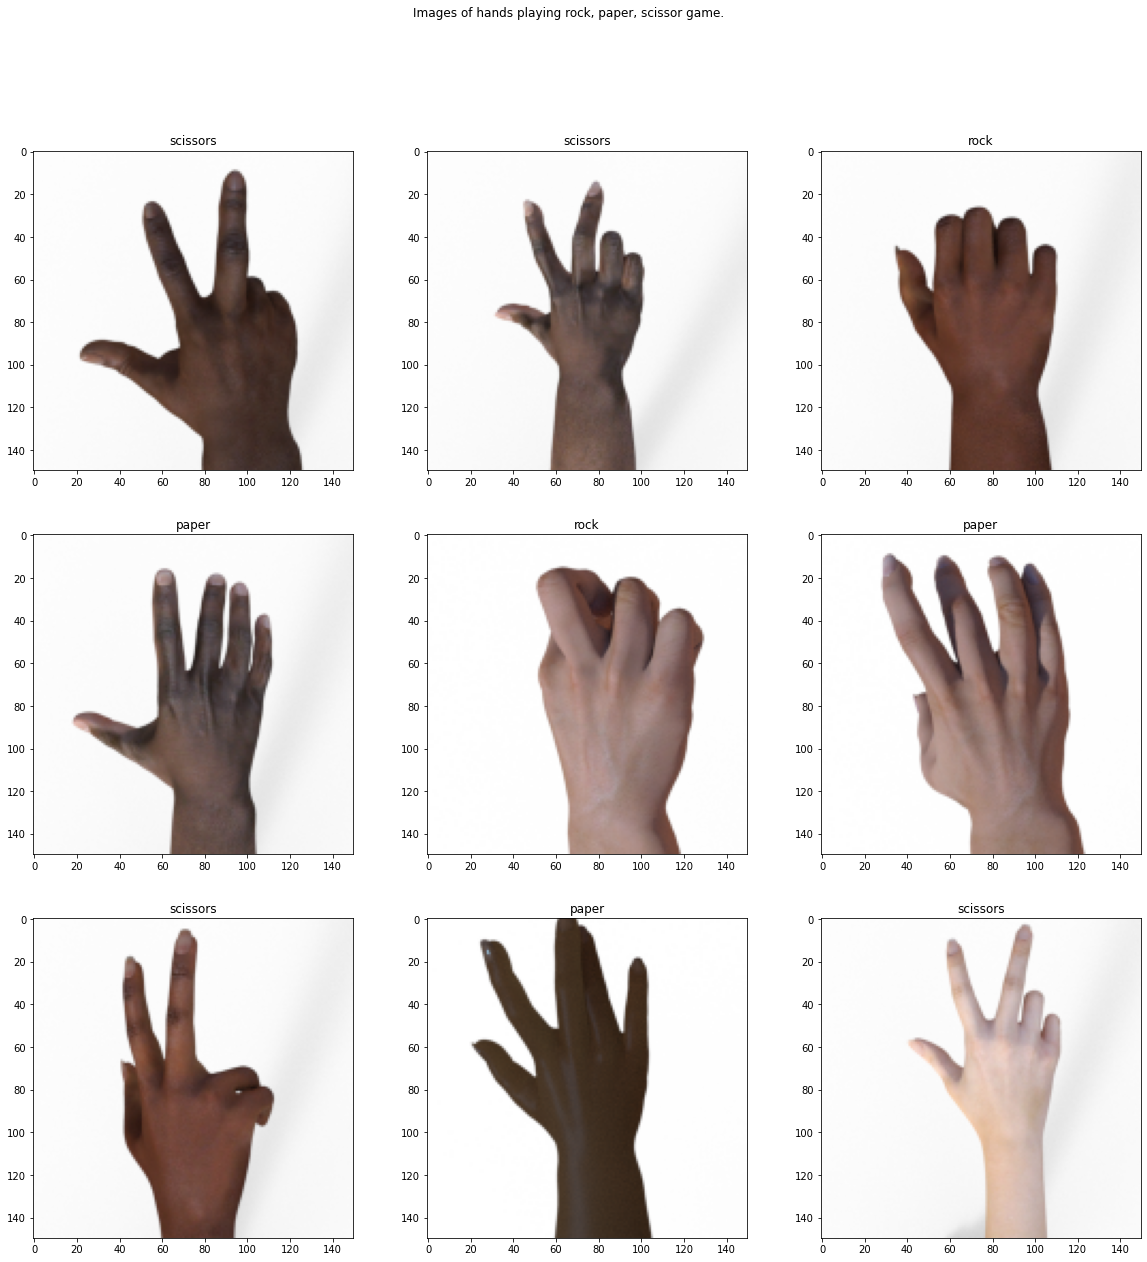

In [14]:
examples(data_train)

## Data Preparation

To avoid overfitting of the CNN, we need to apply different funtions to augment the images.

Random flip image:
```
flip_c(data)
```

Adjust color:
```
color_c(data)
```

Rotate some of the images:
```
rotation_c(data)
```

Invert some of the images:
```
inversion_c(data)
```


Use all above functions:
```
augment_c(data)
```





In [ ]:
def flip_c(image: tf.Tensor) -> tf.Tensor:
    # Randomize alignment (left/right)
    image = tf.image.random_flip_left_right(image)
    # Randomize alignment (top/down)
    image = tf.image.random_flip_up_down(image)
    # Return the randomized image
    return image

In [ ]:
def color_c(image: tf.Tensor) -> tf.Tensor:
    # Randomize hue
    image = tf.image.random_hue(image, max_delta=0.08)
    # Randomize saturation
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    # Randomize brightness
    image = tf.image.random_brightness(image, 0.05)
    # Randomize contrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    # Return the randomized image
    return image

In [ ]:
def rotation_c(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    # Return the randomized image
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )

In [ ]:
def inversion_c(image: tf.Tensor) -> tf.Tensor:
  # Invert the submitted tensor
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.5:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    # Return the randomized image
    return image

In [ ]:
def augment_c(image, label):
  # Randomize alignment
  image = flip_c(image)
  # Randomize color (saturation/hue/brightness/contrast)
  image = color_c(image)
  # Randomize rotation
  image = rotation_c(image)
  # Randomize inversion
  image = inversion_c(image)
  # Return the fully randomized image
  return image, label

In [ ]:
# Iterate over all tensor objects and augment them with custom augment function
# Only train set needs to be augmented
data_train_prepared = data_train.map(augment_c)

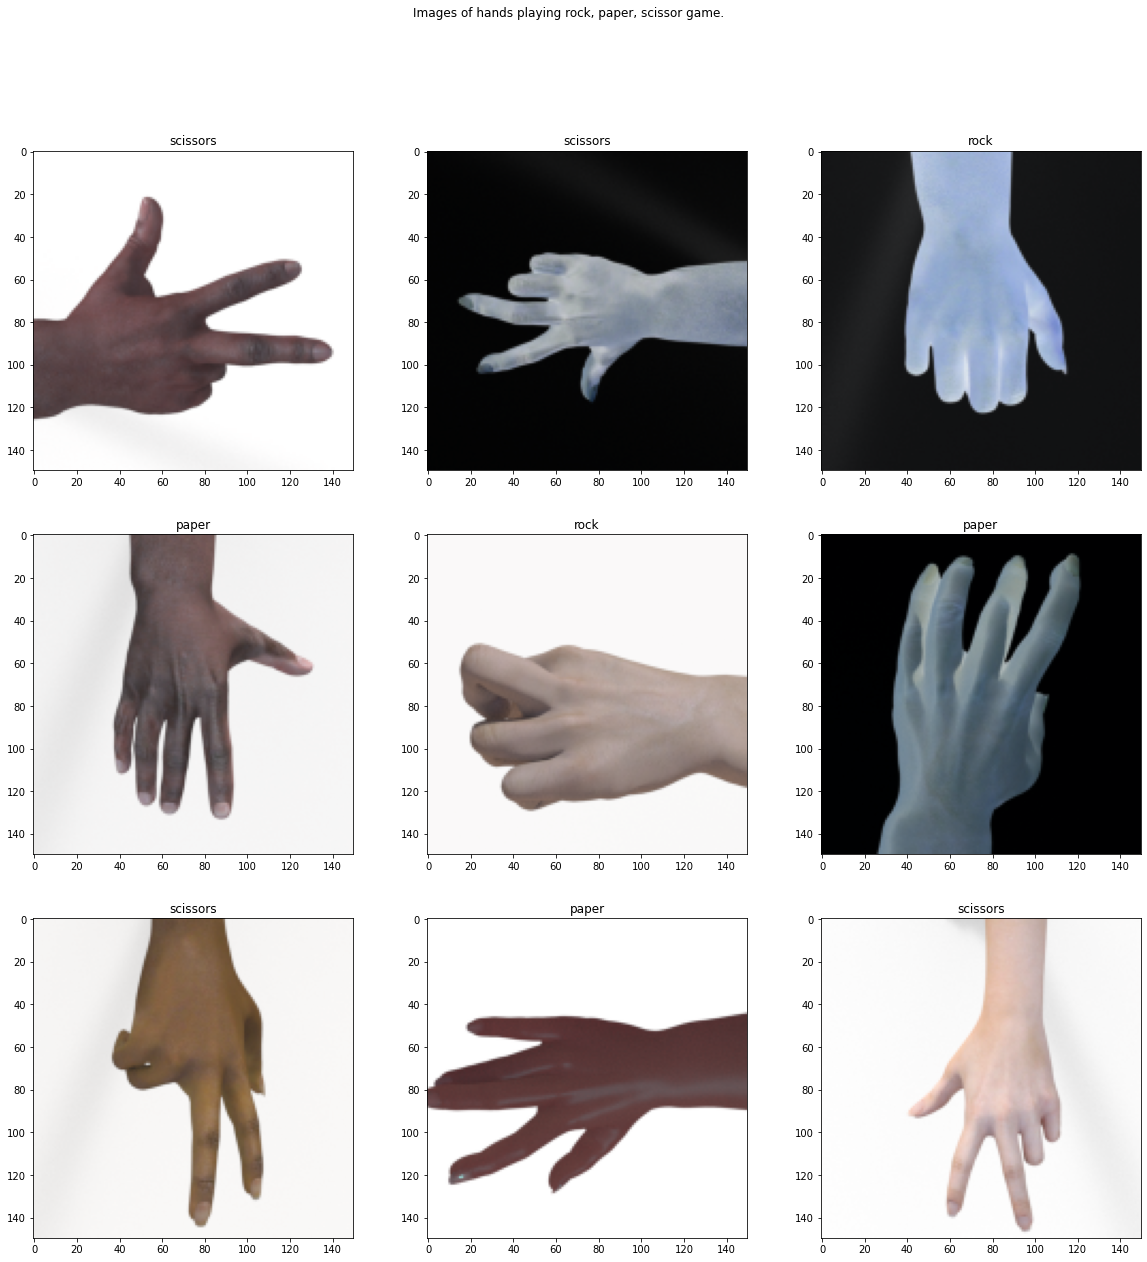

In [ ]:
# Show augmented data
examples(data_train_prepared)

In [ ]:
# BATCHING
from tensorflow.data.experimental import AUTOTUNE

BATCH = 32

data_train_prepared = data_train_prepared.shuffle(
    buffer_size=ds_info.splits['train'].num_examples
)

data_train_prepared = data_train_prepared.batch(
    batch_size=BATCH
)

data_train_prepared = data_train_prepared.prefetch(
    buffer_size=AUTOTUNE
)

data_test_prepared = data_test.batch(BATCH)

## CNN Architecture

In [ ]:
# Import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
# Feature extraction layers
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Activation, Dropout
# Classification layers
from tensorflow.keras.layers import Dense, Flatten

In [ ]:
INPUT_SHAPE = (
    ds_info.features['image'].shape[0] // 2,
    ds_info.features['image'].shape[0] // 2,
    ds_info.features['image'].shape[2]
)

In [ ]:
model = Sequential()

# FEATURE EXTRACTION
# Convolutional layer 1
model.add(Convolution2D(
    input_shape=INPUT_SHAPE,
    filters=64,
    kernel_size=3,
    activation='relu',
    name='Conv1'
))

model.add(MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2),
    name='MaxPool1'
))

# Convolutional layer 2
model.add(Convolution2D(
    filters=64,
    kernel_size=3,
    activation='relu',
    name='Conv2'
))

model.add(MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2),
    name='MaxPool2'
))

# Convolutional layer 3
model.add(Convolution2D(
    filters=128,
    kernel_size=3,
    activation='relu',
    name='Conv3'
))

model.add(MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2),
    name='MaxPool3'
))

# Convolutional layer 4
model.add(Convolution2D(
    filters=128,
    kernel_size=3,
    activation='relu',
    name='Conv4'
))

model.add(MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2),
    name='MaxPool4'
))

# Flatten layers
model.add(Flatten(
    name='FLATTEN'
))
# Add a dropout layer against overfitting
model.add(Dropout(
    rate=.5,
    name='DROPOUT'
))

# Add a dense layer
model.add(Dense(
    units=512,
    activation='relu',
    name='DENSE512'
))

# Dense layer as output layer
model.add(Dense(
    units=len(labels),
    activation='softmax',
    name='OUTPUT_SOFTMAX'
))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 148, 148, 64)      1792      
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 74, 74, 64)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 72, 72, 64)        36928     
_________________________________________________________________
MaxPool2 (MaxPooling2D)      (None, 36, 36, 64)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 34, 34, 128)       73856     
_________________________________________________________________
MaxPool3 (MaxPooling2D)      (None, 17, 17, 128)       0         
_________________________________________________________________
Conv4 (Conv2D)               (None, 15, 15, 128)       1

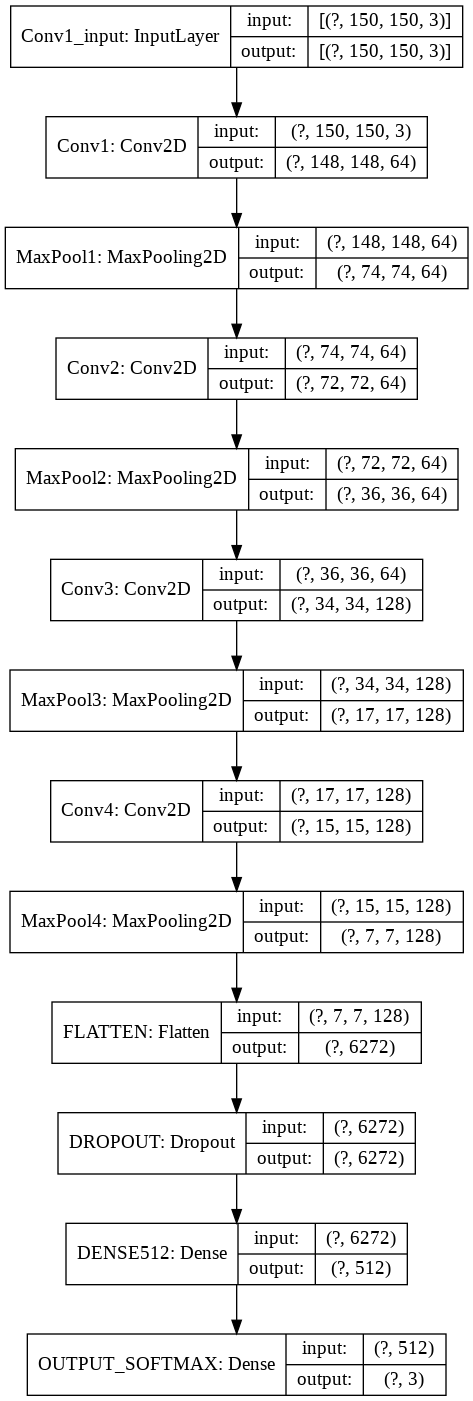

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='CNN_model.png', show_shapes=True, show_layer_names=True)

In [38]:
# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"], 
    optimizer='sgd')

In [39]:
# Check training data
print(data_train_prepared)
# Check test data
print(data_test_prepared)

<PrefetchDataset shapes: ((None, 150, 150, 3), (None,)), types: (tf.float32, tf.int64)>
<BatchDataset shapes: ((None, 150, 150, 3), (None,)), types: (tf.float32, tf.int64)>


In [40]:
history = model.fit(
    x=data_train_prepared.repeat(),
    validation_data=data_test_prepared.repeat(),
    epochs=20,
    steps_per_epoch=78,
    validation_steps=11,
    verbose=1
)

Epoch 1/20
 2/78 [..............................] - ETA: 4s - loss: 0.1835 - accuracy: 0.9219WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0291s vs `on_train_batch_end` time: 0.0467s). Check your callbacks.


78/78 [==============================] - 6s 79ms/step - loss: 0.2931 - accuracy: 0.8878 - val_loss: 0.3891 - val_accuracy: 0.8381
Epoch 2/20
78/78 [==============================] - 15s 198ms/step - loss: 0.2914 - accuracy: 0.8871 - val_loss: 0.6006 - val_accuracy: 0.6847
Epoch 3/20
78/78 [==============================] - 15s 196ms/step - loss: 0.2627 - accuracy: 0.9072 - val_loss: 0.4185 - val_accuracy: 0.8239
Epoch 4/20
78/78 [==============================] - 15s 196ms/step - loss: 0.2432 - accuracy: 0.9019 - val_loss: 0.4680 - val_accuracy: 0.7415
Epoch 5/20
78/78 [==============================] - 16s 201ms/step - loss: 0.2283 - accuracy: 0.9144 - val_loss: 0.4870 - val_accuracy: 0.8239
Epoch 6/20
78/78 [==============================] - 15s 196ms/step - loss: 0.1820 - accuracy: 0.9377 - val_loss: 0.5886 - val_accuracy: 0.7244
Epoch 7/20
78/78 [==============================] - 15s 196ms/step - loss: 0.1688 - accuracy: 0.9429 - val_loss: 0.4254 - val_accuracy: 0.7955
Epoch 8/20
7

In [34]:
history

## Analyse training process

In [35]:
# Show values
print(history.history['accuracy'])
print(history.history['val_accuracy'])

[0.3537660241127014, 0.3918810188770294, 0.40956592559814453, 0.44332796335220337, 0.49276527762413025, 0.5, 0.5401929020881653, 0.5771704316139221, 0.6314308643341064, 0.6700160503387451, 0.7303054928779602, 0.7877813577651978, 0.8183279633522034, 0.8605305552482605, 0.8886656165122986]
[0.3323863744735718, 0.3323863744735718, 0.3607954680919647, 0.4573863744735718, 0.3323863744735718, 0.40909090638160706, 0.3636363744735718, 0.42897728085517883, 0.6136363744735718, 0.4943181872367859, 0.7045454382896423, 0.7727272510528564, 0.7982954382896423, 0.8295454382896423, 0.8465909361839294]


In [36]:
# Show epochs
history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

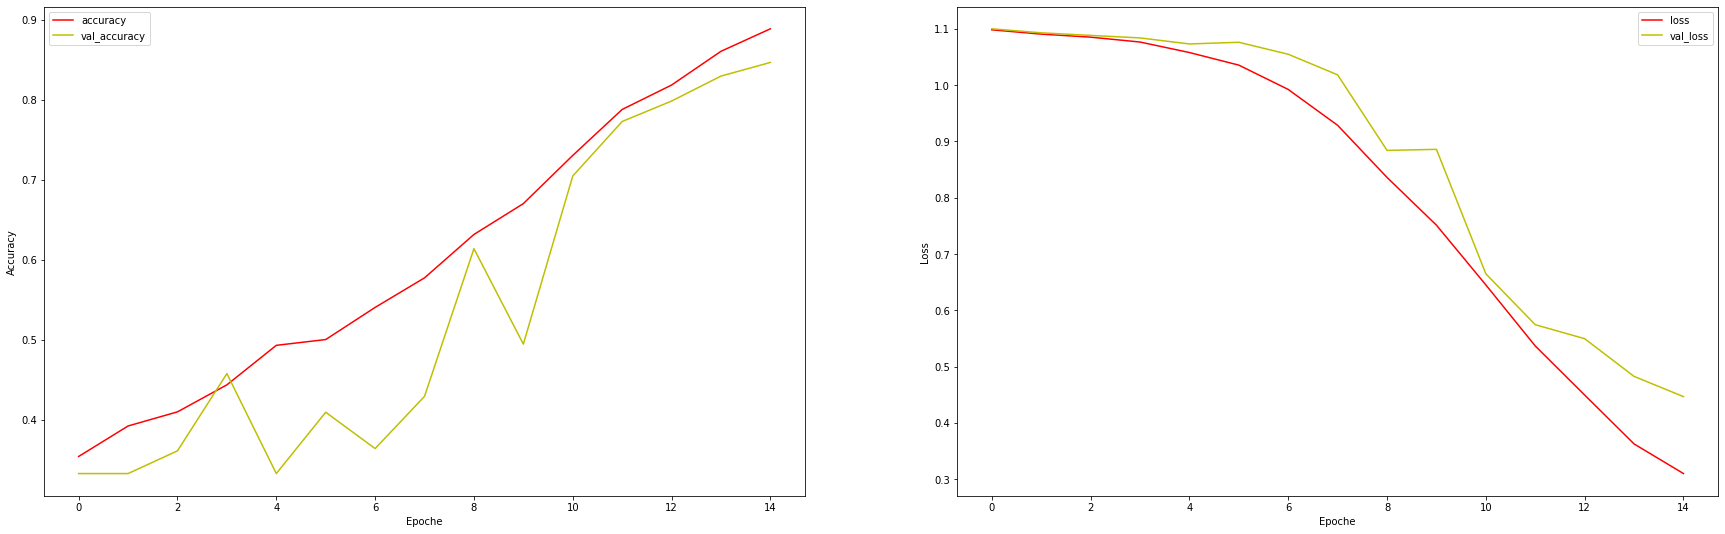

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30,9))

ax[0].plot(history.history['accuracy'], label='accuracy', color='r')
ax[0].plot(history.history['val_accuracy'], label ='val_accuracy', color='y')
ax[0].set_xlabel('Epoche')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(history.history['loss'], label='loss', color='r')
ax[1].plot(history.history['val_loss'], label ='val_loss', color='y')
ax[1].set_xlabel('Epoche')
ax[1].set_ylabel('Loss')
ax[1].legend()